<div style="width: 100%; clear: both;">

<div style="float: left; width: 50%;">

<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">

</div>

<div style="float: right; width: 50%;">

<p style="margin: 0; padding-top: 22px; text-align:right;">M2.991 · Aprenentatge automàtic · PAC1</p>

<p style="margin: 0; text-align:right;">2024-2 · Màster universitari en Ciència de dades (Data science)</p>

<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>

</div>

</div>

<div style="width:100%;">&nbsp;</div>

# PEC 2 - Descobrint patrons ocults: projeccions, agrupacions i significat latent en dades no etiquetades

En aquesta pràctica treballarem amb un [dataset real de sessions d'escolta de música procedent de 1000 usuaris de LastFM](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html). A partir d'aquest escenari, aprendràs a explorar i transformar les dades, a projectar-les en diferents espais i a descobrir estructures ocultes sense necessitat d'etiquetes.

Aplicarem diferents tècniques d'aprenentatge no supervisat per detectar agrupacions i afinitats musicals, entenent millor el comportament dels oients i les relacions entre cançons o artistes.

Començarem **explorant i preparant les dades** per a les diferents tècniques que aplicarem. Donada la gran dimensionalitat de les dades, necessitem representar-les de manera densa a través de diferents tècniques de projecció no supervisades, començarem amb una tècnica basada en **coocurrència** (de cançons o artistes en sessions d'un usuari). Donades les seves limitacions, provarem dos mètodes de projecció alternatius: un **probabilístic** (LDA que a més és un algoritme de clustering) i un altre que **factoritza matrius** (ALS que a més ens permet fer recomanacions). *Opcionalment* es presenta l'oportunitat d'explorar les **projeccions algebraiques** a través d'una versió simplificada d'un model item2vec.

**Important:** cadascun dels exercicis pot suposar diversos minuts d'execució (molts mètodes utilitzats a la pràctica tenen un paràmetre anomenat `n_jobs` que amb valor `-1` paral·leliza tasques i pot reduir els temps d'execució), per la qual cosa el lliurament s'ha de fer en format notebook i en format html, on es vegi el codi, els resultats i comentaris de cada exercici. Es pot exportar el notebook a html des del menú File $\to$ Download as $\to$ HTML.

**Important:** existeix un tipus de cel·la especial per albergar text. Aquest tipus de cel·la us serà molt útil per respondre a les diferents preguntes teòriques plantejades al llarg de cada PEC. Per canviar el tipus de cel·la a aquest tipus, trieu al menú: Cell $\to$ Cell Type $\to$ Markdown.

**Important:** la solució plantejada no ha d'utilitzar mètodes, funcions o paràmetres declarats "deprecated" en futures versions.

**Important:** és convenient que utilitzeu una llavor amb un valor fix (en aquest Notebook se us proposa la variable _seed_ inicialitzada a 100) en tots aquells mètodes o funcions que continguin alguna component aleatòria per assegurar-vos que obtindreu sempre el mateix resultat en les diferents execucions del vostre codi.

**Important:** no oblideu posar el vostre nom i cognoms a la següent cel·la.

<div class="alert alert-block alert-info">
<strong>Nom i cognoms: Marc Cervera Rosell</strong>
</div>

Per a la realització de la pràctica necessitarem instal·lar i importar els següents mòduls:

In [1]:
!pip install smogn==0.1.2
!pip install implicit
!pip install matplotlib-venn
#!apt-get -qq install -y libfluidsynth1
!pip install adjustText

In [2]:
from collections import defaultdict
from itertools import permutations
import pickle
import random
import warnings

from adjustText import adjust_text
from implicit.als import AlternatingLeastSquares
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import LatentDirichletAllocation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import tqdm
import umap

%matplotlib inline


# 1. Preparació de les dades: LastFM 1K (1 punt)

Treballarem amb una versió del dataset LastFM 1K, un conjunt real de dades recopilat des de la plataforma musical Last.fm. Conté l'historial d'escolta d'aproximadament 1.000 usuaris, on es registren les cançons que cada usuari ha escoltat, amb informació sobre:

- L'usuari (en format id)

- La data i hora de reproducció

- L'artista (en format id i nom)

- La cançó (en format id i títol)

Per a això pots carregar les dades de la següent manera:

In [3]:
df = pd.read_csv("music_sample.tsv", sep="\t", header=0)

In [4]:
df.sample(5)

,user_id,artist,track
210288,user_000857,The Doors,The Unknown Soldier
301367,user_000977,The Last Shadow Puppets,The Age Of The Understatement
199621,user_000427,Jackson Browne,Before The Deluge
375161,user_000877,Marcus Miller,Visions
177673,user_000147,Siouxsie And The Banshees,Take Me Back


## 1.1 Eliminar duplicats

Un mateix usuari pot haver escoltat una mateixa cançó diverses vegades al llarg del temps. Com que en aquest cas no ens interessa quan va ocórrer cada escolta, eliminarem els registres duplicats.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Conserva només una fila per combinació d'`usuari`, `artista` i `cançó`, ignorant el `timestamp`.
</div>


In [5]:
# Eliminació de línies corrompudes
df.dropna(inplace=True)
df = df[~df['track'].str.contains(r"\t")]

In [6]:
df.isna().any()

user_id    False
artist     False
track      False
dtype: bool

In [7]:
df_no_duplicates = df.drop_duplicates()

In [8]:
df_no_duplicates.duplicated().any() # Comprovar si hi ha duplicats

False

**Documentació consultada:**

[Pandas.(nd)._pandas.DataFrame.isna_.Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html)

[Pandas.(nd)._pandas.DataFrame.any_.Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.any.html)

[Pandas.(nd)._pandas.DataFrame.drop_duplicates_.Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)

[Pandas.(nd)._pandas.DataFrame.duplicated_.Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html)

## 1.2 Filtratge de cançons amb poca repercussió

Per reduir la mida del dataset i centrar-nos en les cançons amb més rellevància, eliminarem aquelles que hagin tingut molt poca repercussió.

Aquest filtratge ens ajudarà a estalviar **temps de càlcul** i **memòria** en els passos posteriors.





<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Conserva només les cançons que hagin estat escoltades per més de 20 usuaris diferents.
</div>


In [9]:
df_agrupat = df_no_duplicates.groupby(by=["artist", "track"], as_index=False).agg({"user_id":"unique"}) # Agrupar per artista i canço
df_filtrat = df_agrupat[df_agrupat["user_id"].apply(len) > 20] # Seleccionar cançons amb mes de 20 usuaris
df_filtrat

,artist,track,user_id
2501,3 Doors Down,Here Without You,"[user_000270, user_000338, user_000435, user_0..."
2649,30 Seconds To Mars,The Kill,"[user_000300, user_000761, user_000044, user_0..."
5240,A Perfect Circle,3 Libras,"[user_000729, user_000206, user_000912, user_0..."
5274,A Perfect Circle,Imagine,"[user_000341, user_000290, user_000206, user_0..."
5828,A-Ha,Take On Me,"[user_000537, user_000638, user_000374, user_0..."
...,...,...,...
479221,Zero 7,Likufanele,"[user_000609, user_000989, user_000478, user_0..."
479232,Zero 7,Polaris,"[user_000860, user_000153, user_000451, user_0..."
479234,Zero 7,Red Dust,"[user_000734, user_000627, user_000716, user_0..."
479241,Zero 7,Somersault,"[user_000695, user_000159, user_000180, user_0..."


In [10]:
df_filtrat.isna().any()

artist     False
track      False
user_id    False
dtype: bool

**Documentació consultada:**

[Pandas.(nd)._pandas.DataFrame.groupby_.Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)

[Pandas.(nd)._pandas.DataFrame.nunique_.Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html)

[Pandas.(nd)._pandas.DataFrame.agg_.Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html)

## 1.3 Identificació d'artistes i cançons úniques

Generarem tres sèries de pandas que ens seran útils més endavant: una amb tots els **usuaris únics**, una altra amb tots els **artistes únics** i una última amb totes les **cançons úniques** del dataset.

Crea tres objectes `unique_users`, `unique_artists` i `unique_songs`, que continguin els valors únics de `user_id`, `artist` i `artist` + `track`, respectivament, i que tinguin un **índex correlatiu de 0 a N**. Per a això, pots utilitzar `.reset_index(drop=True)` en la teva solució.

A partir de les sèries `unique_artists` i `unique_songs`, crearem quatre diccionaris que ens permetran **mapejar entre noms (strings) i índexs (enters correlatius començant des del 0)**, i viceversa.

Crea els següents diccionaris:

- `user_to_idx`: mapeja l'id d'usuari (str) al seu índex.
- `idx_to_user`: mapeja l'índex a l'id d'usuari (str).

- `artist_to_idx`: mapeja el nom de l'artista al seu índex.
- `idx_to_artist`: mapeja l'índex al nom de l'artista.

- `song_to_idx`: mapeja el nom de la cançó al seu índex.
- `idx_to_song`: mapeja l'índex al nom de la cançó.

Aquests diccionaris seran molt útils per representar el dataset numèricament en etapes posteriors.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Crea els objectes unique_users, user_to_idx, idx_to_user, unique_artists, artist_to_idx, idx_to_artist, unique_songs, song_to_idx i idx_to_song.
</div>


In [108]:
unique_users = pd.Series(df_filtrat["user_id"].explode().unique()).reset_index(drop=True) # Valors unics dels user_id
unique_artists = pd.Series(df_filtrat["artist"].unique()).reset_index(drop=True) # Artistes
unique_songs = pd.Series((df_filtrat["artist"] + "-" + df_filtrat["track"]).unique()).reset_index(drop=True) # Cançó + artista

In [109]:
user_to_idx = {user:index for index, user in enumerate(unique_users)} # Mapping usuaris - index
idx_to_user = {index:user for index, user in enumerate(unique_users)} # Mapping index - usuaris
artist_to_idx = {artist:index for index, artist in enumerate(unique_artists)} # Mapping artista - index
idx_to_artist = {index:artist for index, artist in enumerate(unique_artists)} # Mapping index - artista
song_to_idx = {song:index for index, song in enumerate(unique_songs)} # Mapping canço - index
idx_to_song = {index:song for index, song in enumerate(unique_songs)} # Mapping canço - index

Comprovacions sobre les dades:

In [110]:
print("---------- user_to_idx ----------")
print(user_to_idx)
print("---------- idx_to_user ----------")
print(idx_to_user)
print("---------- artist_to_idx ----------")
print(artist_to_idx)
print("---------- idx_to_artist ----------")
print(idx_to_artist)
print("---------- song_to_idx ----------")
print(song_to_idx)
print("---------- idx_to_song ----------")
print(idx_to_song)

---------- user_to_idx ----------
{'user_000270': 0, 'user_000338': 1, 'user_000435': 2, 'user_000574': 3, 'user_000126': 4, 'user_000824': 5, 'user_000206': 6, 'user_000509': 7, 'user_000363': 8, 'user_000927': 9, 'user_000568': 10, 'user_000894': 11, 'user_000342': 12, 'user_000027': 13, 'user_000039': 14, 'user_000732': 15, 'user_000146': 16, 'user_000393': 17, 'user_000426': 18, 'user_000637': 19, 'user_000978': 20, 'user_000144': 21, 'user_000072': 22, 'user_000650': 23, 'user_000300': 24, 'user_000761': 25, 'user_000044': 26, 'user_000057': 27, 'user_000450': 28, 'user_000725': 29, 'user_000714': 30, 'user_000009': 31, 'user_000329': 32, 'user_000218': 33, 'user_000120': 34, 'user_000661': 35, 'user_000999': 36, 'user_000610': 37, 'user_000902': 38, 'user_000477': 39, 'user_000647': 40, 'user_000037': 41, 'user_000275': 42, 'user_000505': 43, 'user_000766': 44, 'user_000084': 45, 'user_000702': 46, 'user_000847': 47, 'user_000543': 48, 'user_000729': 49, 'user_000912': 50, 'user_

**Documentació consultada:**

[IncludeHelp.(nd)._Keep other columns when using sum() with groupby_.IncludeHelp](https://www.includehelp.com/python/keep-other-columns-when-using-sum-with-groupby.aspx)

[Adel Nehme.(14/02/2024)._Mastering the Pandas .explode() Method: A Comprehensive Guide_.datacamp](https://www.datacamp.com/tutorial/pandas-explode)

[Vultr.(24/12/2024)._Python Pandas DataFrame explode() - Transform Each Iterable_.Vultr](https://docs.vultr.com/python/third-party/pandas/DataFrame/explode)

## 2. Construcció de les matrius de coocurrència usuari-artista i usuari-cançó (3 punts)

Representarem les interaccions entre usuaris i contingut musical en format matricial, la qual cosa ens permetrà treballar amb les dades de forma vectorial en els següents blocs de la pràctica.

Crea dues matrius binàries:

- `user_artist_matrix`: representa si un usuari ha escoltat almenys una vegada a l'artista.
- `user_song_matrix`: representa si un usuari ha escoltat almenys una vegada la cançó.

De tal manera que a la fila i tindrem tots els artistes/cançons que ha escoltat l'usuari i, i tindrà tantes columnes com artistes i cançons hi hagi.

Ambdues matrius tindran valors:

- **1** si l'usuari ha escoltat l'artista o la cançó.
- **0** si no ho ha fet.

Per tant, la cel·la `user_artist_matrix[i,j]` representarà si l'*i-èsim* usuari ha escoltat el *j-èsim* artista.

Aquestes matrius ens permetran codificar els usuaris, artistes i cançons com a vectors i aplicar tècniques de reducció de dimensionalitat, agrupació o recomanació més endavant.

## 2.1 Representació dispersa

Atès que la majoria dels usuaris **no han escoltat la majoria dels artistes ni cançons**, aquestes matrius contenen molts zeros. A aquest tipus de matrius se les anomena **matrius disperses (sparse matrices)**, ja que la majoria dels seus elements són nuls.

Per treballar amb elles de forma eficient en memòria i en càlcul, farem servir el format **CSR (Compressed Sparse Row)**. Aquest format emmagatzema només els valors diferents de zero juntament amb les seves posicions, la qual cosa permet estalviar memòria i accelerar algunes operacions.

Construirem les matrius en [format **`csr_matrix`** de la llibreria `scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html).



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Crea les matrius de coocurrència.
</div>

In [120]:
# Matriu usuaris i artistes
user_artist_matrix_no_csr = np.zeros((len(unique_users), len(unique_artists)), dtype=int) # Construir una matriu de 0
indexes_users = []
for _, row in df_filtrat.iterrows():
    indexes_users = []
    index_artista = artist_to_idx[row["artist"]] # Index artista
    for user in row["user_id"]:
        indexes_users.append(user_to_idx[user]) # Usuaris que han escoltat l'artista
    for listener in indexes_users:
        user_artist_matrix_no_csr[listener, index_artista] = 1 # Assignar 1 a l'usiari i que ha escoltat l'artista j
user_artist_matrix = csr_matrix(user_artist_matrix_no_csr)

In [121]:
# Matriu cançons - usuaris
user_song_matrix_no_csr = np.zeros((len(unique_users), len(unique_songs)), dtype=int) # Construir una matriu de 0
indexes_users = []
for _, row in df_filtrat.iterrows():
    indexes_users = []
    complete_key = str(row["artist"] + "-" + row["track"]) # Per buscar al diccionari de cançons
    index_song = song_to_idx[complete_key] # Index cançó
    for user in row["user_id"]:
        indexes_users.append(user_to_idx[user]) # Guardar usuaris (indexs)
    for listener in indexes_users:
        user_song_matrix_no_csr[listener, index_song] = 1 # Assignar 1 on correspongui
user_song_matrix = csr_matrix(user_song_matrix_no_csr)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Per conèixer el grau de dispersió que té la matriu, podem calcular la proporció d'1s respecte al total d'elements de la matriu: user_song_matrix.
</div>

In [124]:
num_ones = user_song_matrix.count_nonzero() # Comptar 1s
items = user_song_matrix.shape[0] * user_song_matrix.shape[1] # Nombre total d'elements de la matriu
proportion = num_ones / items
print(f"La proporció de uns és del {proportion}% ")

La proporció de uns és del 0.029806327506349917% 


**Documentació consultada:**

[NumPy.(nd)._numpy.zeros_.NumPy](https://numpy.org/devdocs/reference/generated/numpy.zeros.html)

[SciPy.(nd)._scipy.parse.csr_matrix_.SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)

[Pandas,(nd)._pandas.DataFrame.iterrows_.Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html)

[SciPy.(nd)._scipy.sparse.csr_matrix.count_nonzero_.SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.count_nonzero.html)

## 2.2 Visualització de l'espai d'usuaris

Ara que cada usuari està representat com un vector a les matrius `user_artist_matrix` o `user_song_matrix`, podem començar a **explorar visualment l'estructura de gustos musicals**.

Cada fila d'aquestes matrius codifica un usuari en funció dels artistes o cançons que ha escoltat. L'objectiu ara és **projectar aquest espai a 2 dimensions** per visualitzar-lo i tractar de detectar **grups d'usuaris amb patrons similars d'escolta**.

Tanmateix, en el cas de la matriu d'artistes, cada usuari està representat per un vector de gairebé **3.000 dimensions**, la qual cosa fa impossible visualitzar directament l'espai.

Per resoldre això, aplicarem una tècnica de **reducció de dimensionalitat** que ens permeti mantenir l'estructura de l'espai original i projectar-lo en 2D. Algunes de les tècniques més comunes per a aquest tipus de tasca són: *PCA (Anàlisi de Components Principals)*, *t-SNE (t-distributed Stochastic Neighbor Embedding)* o *UMAP (Uniform Manifold Approximation and Projection)*. Tingues en compte que amb el temps tindrem nous usuaris i voldrem afegir-los a la projecció de l'espai juntament amb els altres usuaris que ja tenim (sense haver de recalcular tot).



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> investiga i justifica quina d'aquestes tècniques consideres més adequada per a aquest cas indicant els criteris que has tingut en compte.
</div>

L'algorisme PCA és una tècnica de reducció utilitzada per a simplificar i entendre conjunts de dades que són grans i complexos. Per fer-ho possible, redueix la dimensionalitat de les dades trobant noves variables que capturen els patrons més importants del dataset. A diferència d'altres tècniques, PCA se centra a trobar les relacions lineals de les dades en l'àmbit global (en altres paraules, intenta mantenir la variància de les dades). És una tècnica molt útil per identificar quins són els aspectes més importants per diferenciar les dades, i permet resumir-les en menys dimensions per a poder-les entendre millor. Els valors atípics, però, són un tema complex en aquest algorisme, ja que PCA es pot veure molt afectat per aquests valors i poden portar a resultats falsos. A més és una tècnica computacionalment barata, especialment per conjunts de dades grans. L'algorisme PCA és molt útil en tasques de selecció de features, compressió de dades i reducció de soroll.

La tècnica t-SNE és una tècnica de visualització que ajuda a entendre i explorar dades de dimensions altes que emfatitza en preservar, a diferència de la tècnica anterior, les relacions locals i els _clusters_ dins de les dades. L'algorisme t-SNE construeix una representació de baixes dimensions on dades semblants es col·loquen juntes (en _clusters_). Aquesta tècnica és molt útil per visualitzar dades de conjunts complexos i per identificar patrons que poden no ser obvis en l'espai d'alta dimensió. T-SNE és usat molt freqüentment en tasques de _EDA_, reconeixement de patrons i tasques de _clustering_. T-SNE pot esdevenir computacionalment car en _datasets_ grans (complexitat quadratica).

L'última tècnica proposada és l'algorisme UMAP. Aquesta tècnica és, com l'anterior, una tècnica de reducció de la dimensionalitat i de visualització. UMAP, simplifica les dades del dataset i manté a proximitat entre els punts. L'algorisme UMAP se serveix de múltiples aprenentatges per entendre l'estructura de les dades i se centra a captar relacions complexes i no lineals. Aquestes relacions podrien no ser detectades amb els algorismes PCA i t-SNE. Finalment, UMAP és una tècnica escalable capaç de suportar conjunts de dades grans de manera eficient, fent aquesta tècnica adequada per a tasques de visualització i exploració. Generalment, UMAP es cimputacionalment més ràpid que la tècnica anterior, donant com a resultat visualitzacions d'alta qualitat amb menys cost de recursos.

Després d'analitzar les diferents opcions proposades, es conclou que la millor opció, és la tècnica UMAP, ja que l'objectiu és una tasca de visualització. També es considera que aquesta és la millor elecció perquè a diferència de PCA, UMAP entén patrons no lineals i és més ràpid que t-SNE. A més a més, s'escull UMAP per la seva escalabilitat, la qual permetrà afegir més usuaris en el futur.

**Documentació consultada:**

[Sung Mo Park.(15-07-2023)._Easy explanation of the dimension reduction (PCA, t-SNE, and UMAP)_.Linkedin](https://www.linkedin.com/pulse/easy-explanation-dimension-reduction-pca-t-sne-umap-sung-mo-park/)

[Multiples autors.(2022)._PCA vs UMAP vs t-SNE: On a very layman level, what are the differences between these dimensionality reduction techniques and when should we use one over the other?_.Reddit](https://www.reddit.com/r/datascience/comments/wy1rmk/pca_vs_umap_vs_tsne_on_a_very_layman_level_what/)

[Medium.(2-07-2024)._Understanding Dimensionality Reduction: PCA vs t-SNE vs UMAP vs FIt-SNE vs LargeVis vs Laplacian Eigenmaps_.Medium](https://carnotresearch.medium.com/understanding-dimensionality-reduction-pca-vs-t-sne-vs-umap-vs-fit-sne-vs-largevis-vs-laplacian-13d0be9ef7f4)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Visualitza el resultat de la reducció en un gràfic 2D amb matplotlib i comenta si s'observen agrupaments o patrons interessants en ambdues matrius. En cas de trobar estructures, tria i aplica la tècnica de clustering adequada per localitzar-les. En funció de les estructures presents, pots seleccionar k-means, LDA, jeràrquic, mean-shift, optics, DBSCAN o espectral. <strong>En tots els gràfics, utilitza el paràmetre figsize=(15, 15) per garantir una mida que permeti interpretar-lo correctament</strong>.
</div>

In [139]:
# UMAP a matriu d'artistes
reducer_artist = umap.UMAP(n_components=2)
artist_umap = reducer_artist.fit_transform(user_artist_matrix)
# UMAP a matriu de cançons
reducer_songs = umap.UMAP(n_components=2)
songs_umap = reducer_songs.fit_transform(user_song_matrix)

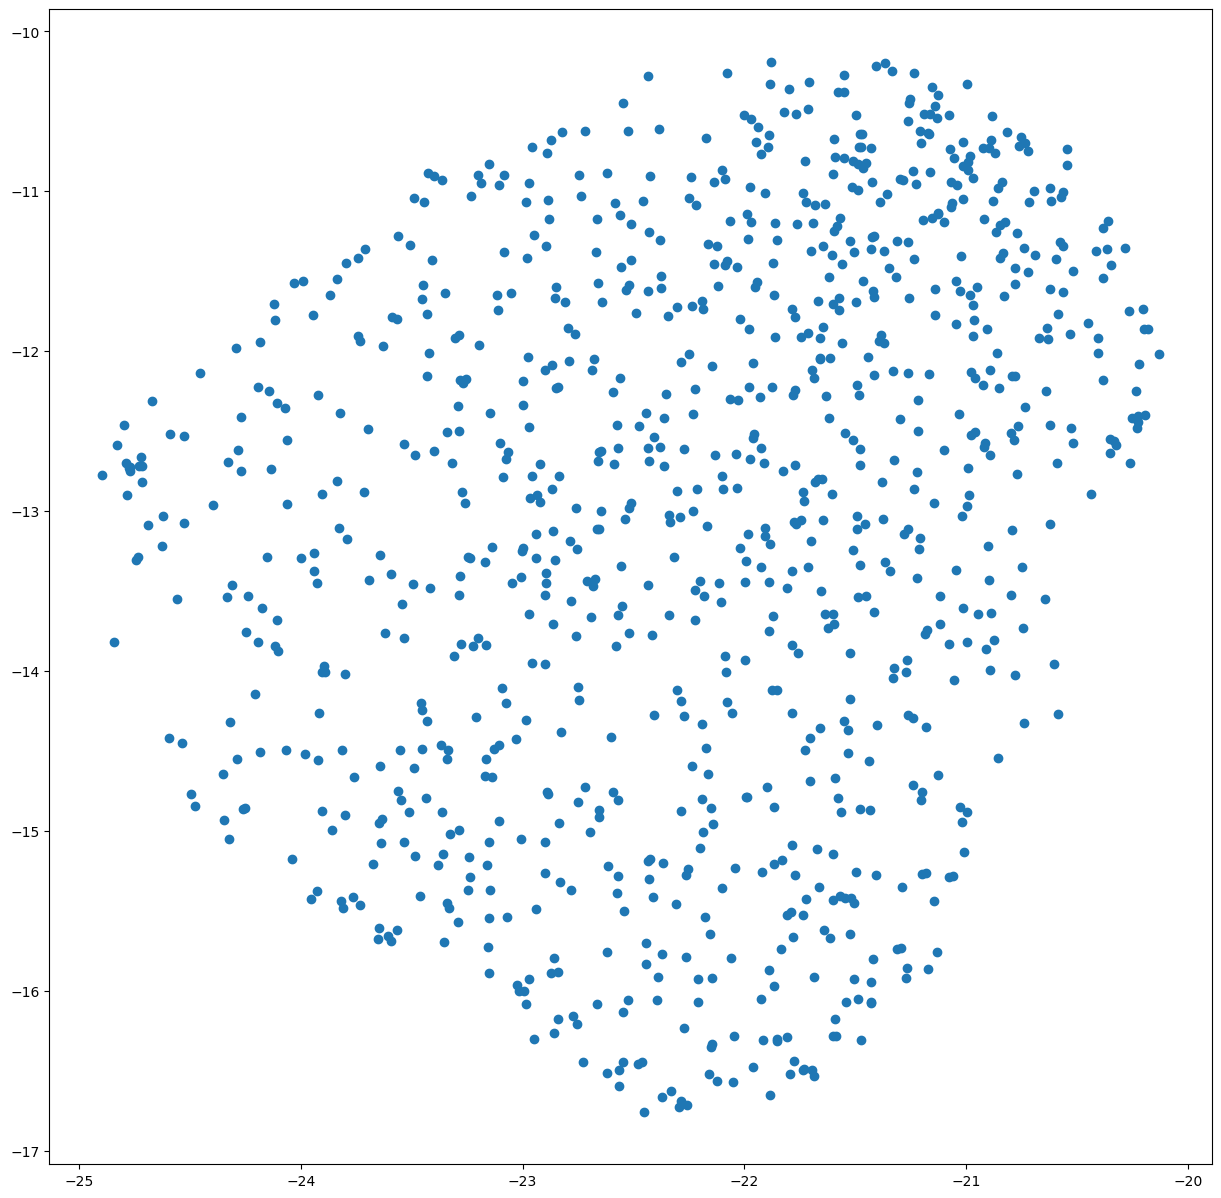

In [163]:
# Gràfic artistes
plt.figure(figsize=(15,15))
plt.scatter(artist_umap[:, 0], artist_umap[:, 1])
plt.show()

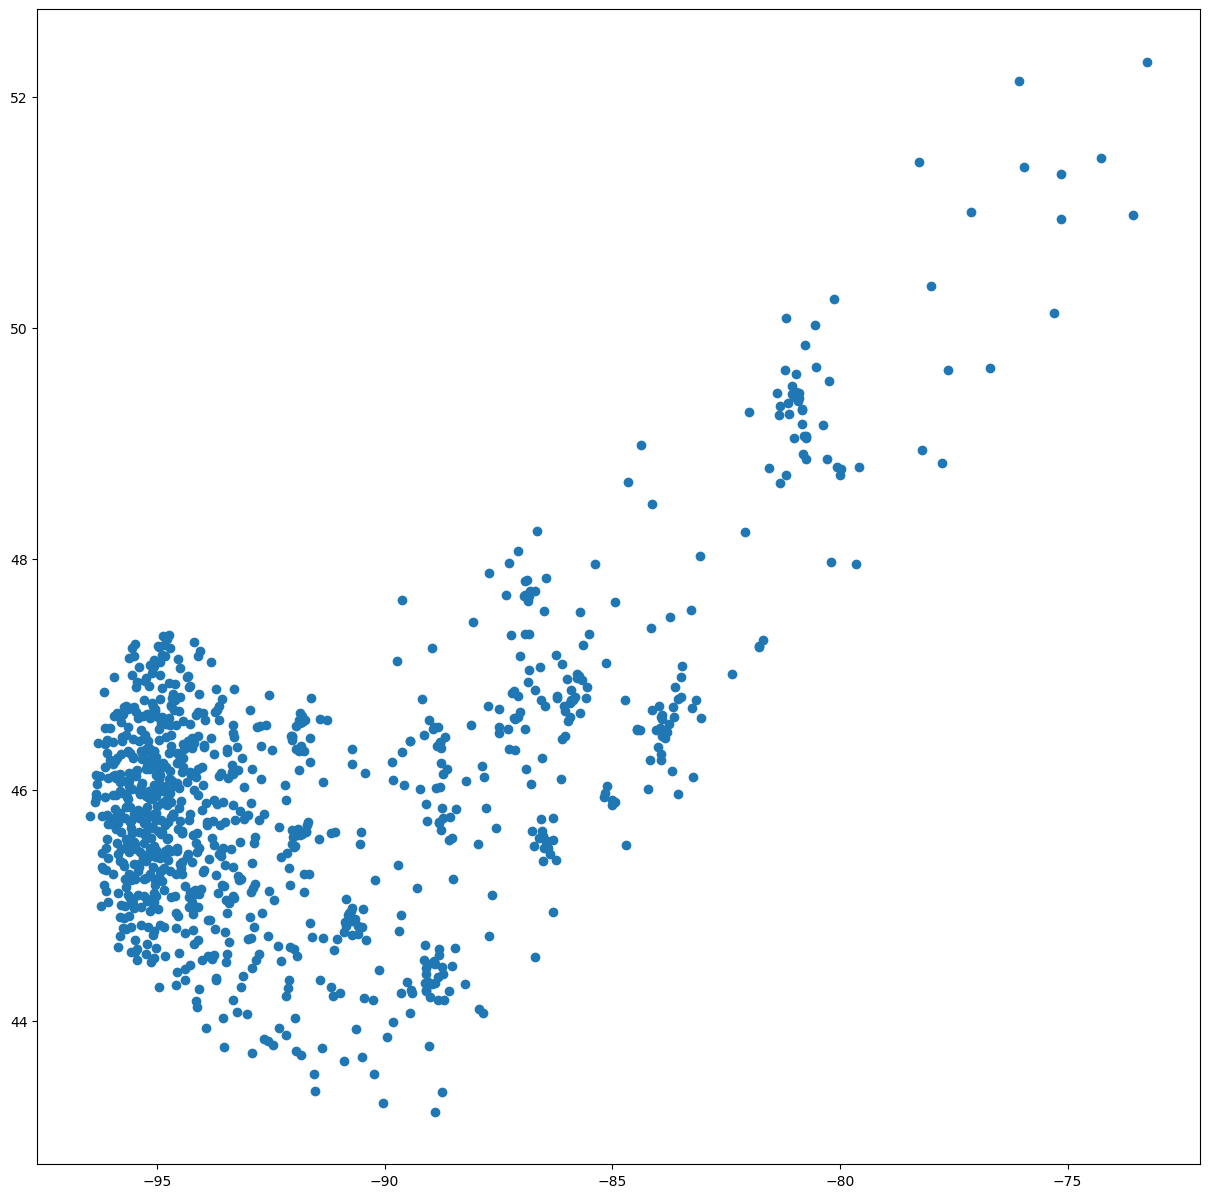

In [164]:
# Gràfic cançons
plt.figure(figsize=(15,15))
plt.scatter(songs_umap[:, 0], songs_umap[:, 1])
plt.show()

En el cas de la matriu de artistes, no s'observen agrupaments molt marcats. En canvi per la matriu de cançons es pot observar el contrari es poden considerar entre 3 i 4 agrupacions.

In [172]:
from sklearn.cluster import KMeans
# k-means per cançons
clusered_kmeans_songs_3 = KMeans(n_clusters=3)
clusered_kmeans_songs_3.fit(songs_umap)

KMeans(n_clusters=3)

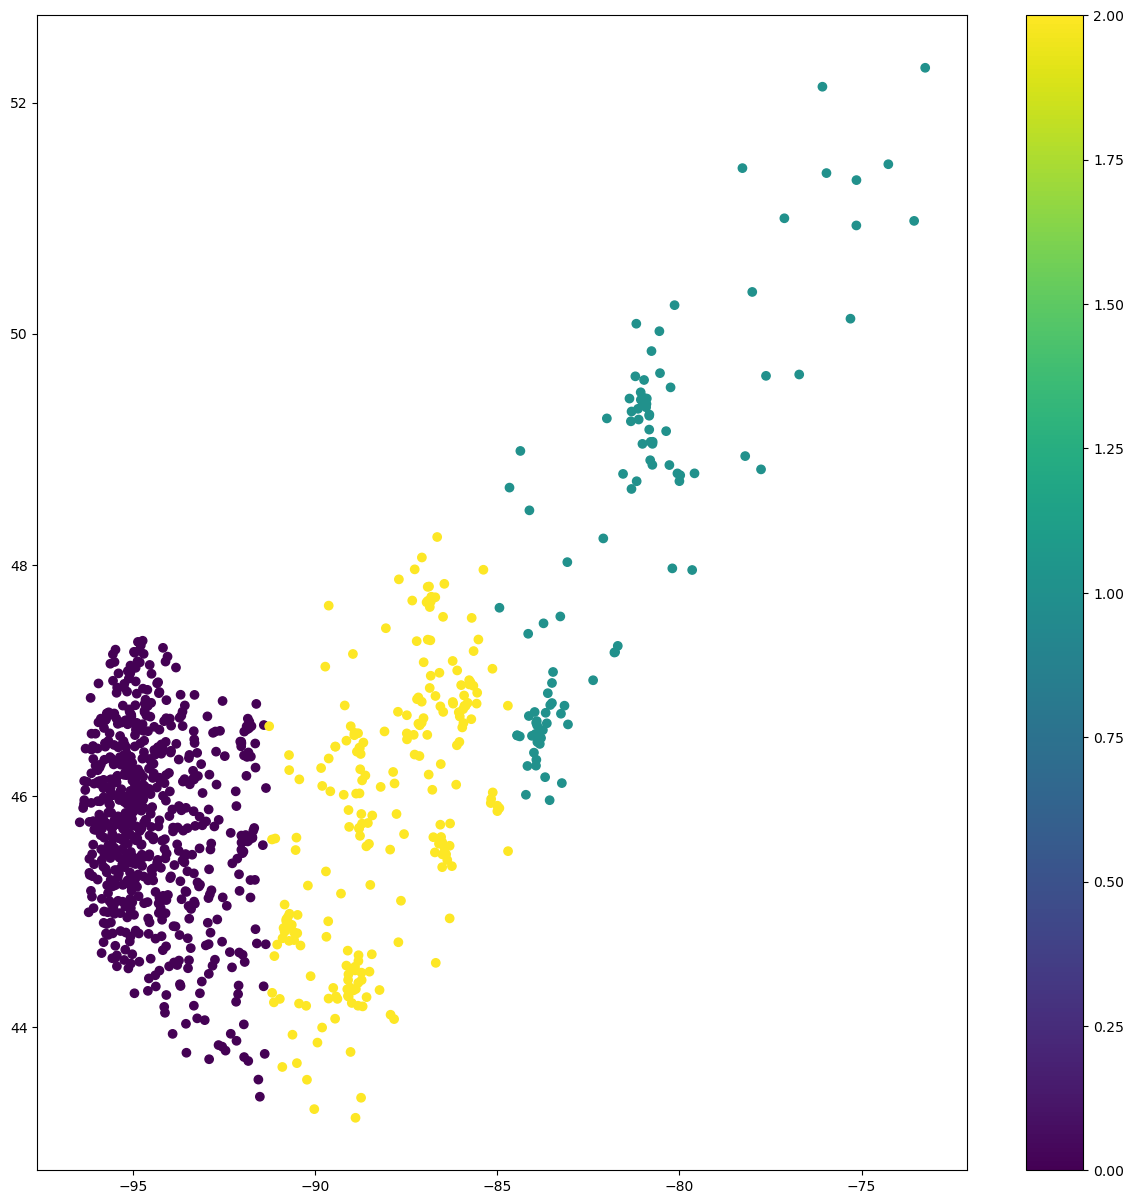

In [173]:
# Gràfic cançons
plt.figure(figsize=(15,15))
plt.scatter(songs_umap[:, 0], songs_umap[:, 1], c=clusered_kmeans_songs_3.labels_)
plt.colorbar()
plt.show()

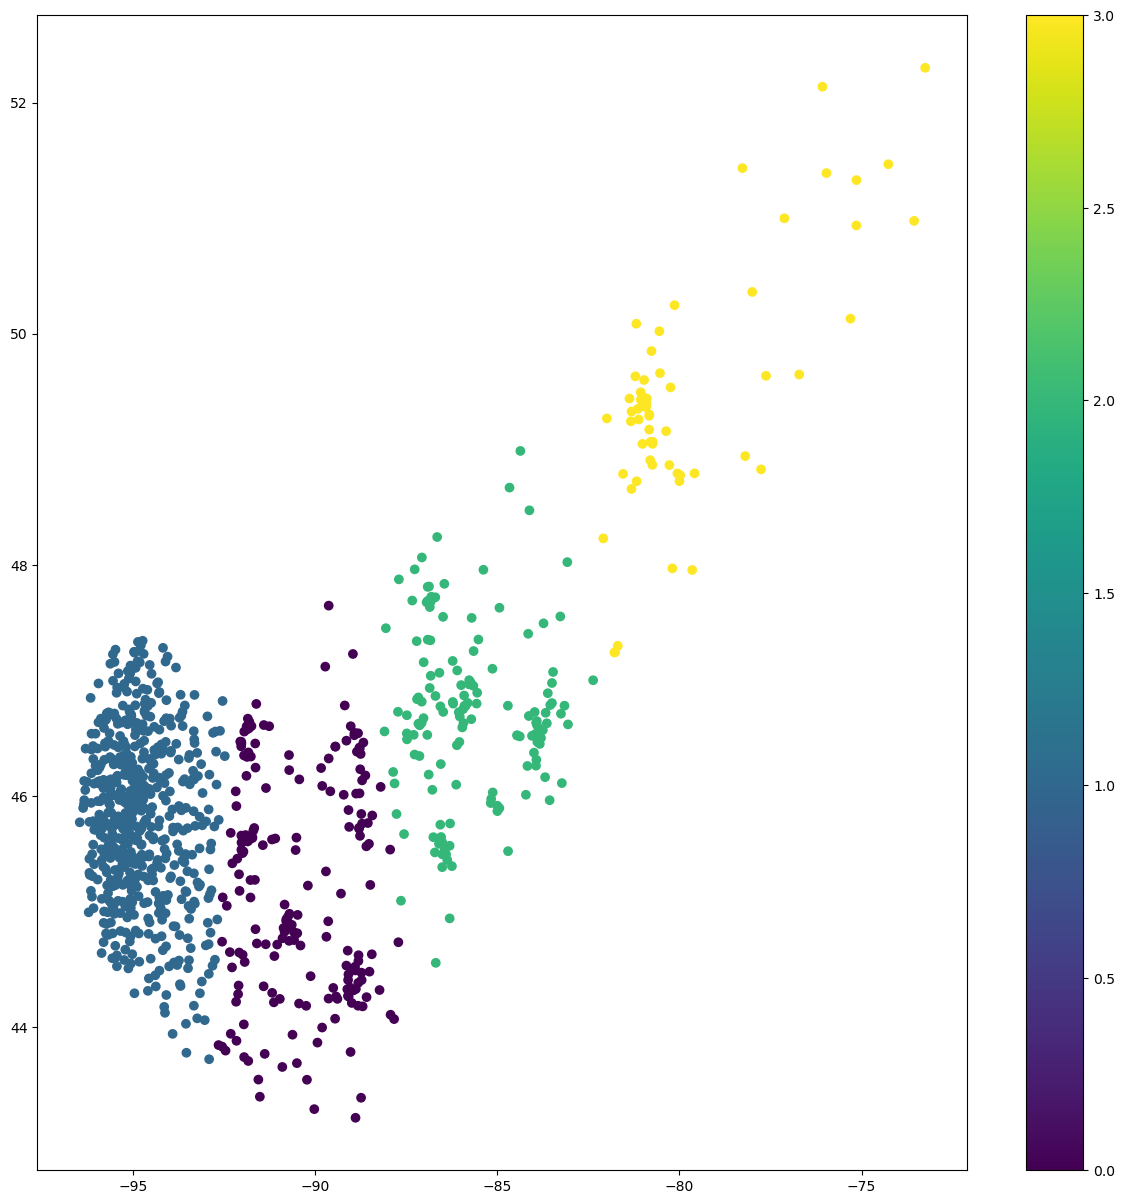

In [174]:
# k-means per cançons
clusered_kmeans_songs_4 = KMeans(n_clusters=4)
clusered_kmeans_songs_4.fit(songs_umap)
# Gràfic cançons
plt.figure(figsize=(15,15))
plt.scatter(songs_umap[:, 0], songs_umap[:, 1], c=clusered_kmeans_songs_4.labels_)
plt.colorbar()
plt.show()

Com que per la matriu de artistes no s'han observat agrupacions clares, no s'aplicarà cap tècnica de _clustering_.

**Documentació consultada:**

[UMAP.(nd)._How to Use UMAP_.UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)

[UMAP.(nd)._Basic UMAP Parameters_.UMAP](https://umap-learn.readthedocs.io/en/latest/parameters.html#n-components)

[scikit-learn.(nd)._KMeans_.scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

## 2.3 Visualització d'usuaris

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Realitza la mateixa visualització però amb les matrius transposades, és a dir, mantindrem les dimensions d'artistes i cançons, i reduirem la d'usuaris. La seva interpretació seria representar els artistes o cançons en funció de com els usuaris els consumeixen.
</div>


In [175]:
# Transposar matrius
csr_artists_transposed = user_artist_matrix.transpose()
cs_songs_transposed = user_song_matrix.transpose()

# UMAP a les transposades
reducer_artists_transposed = umap.UMAP(n_components=2)
umap_artists_transposed = reducer_artists_transposed.fit_transform(csr_artists_transposed)

reducer_songs_transposed = umap.UMAP(n_components=2)
umap_songs_transposed = reducer_songs_transposed.fit_transform(cs_songs_transposed)

C:\Users\mcr99\anaconda3\envs\env_uoc202402pec2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


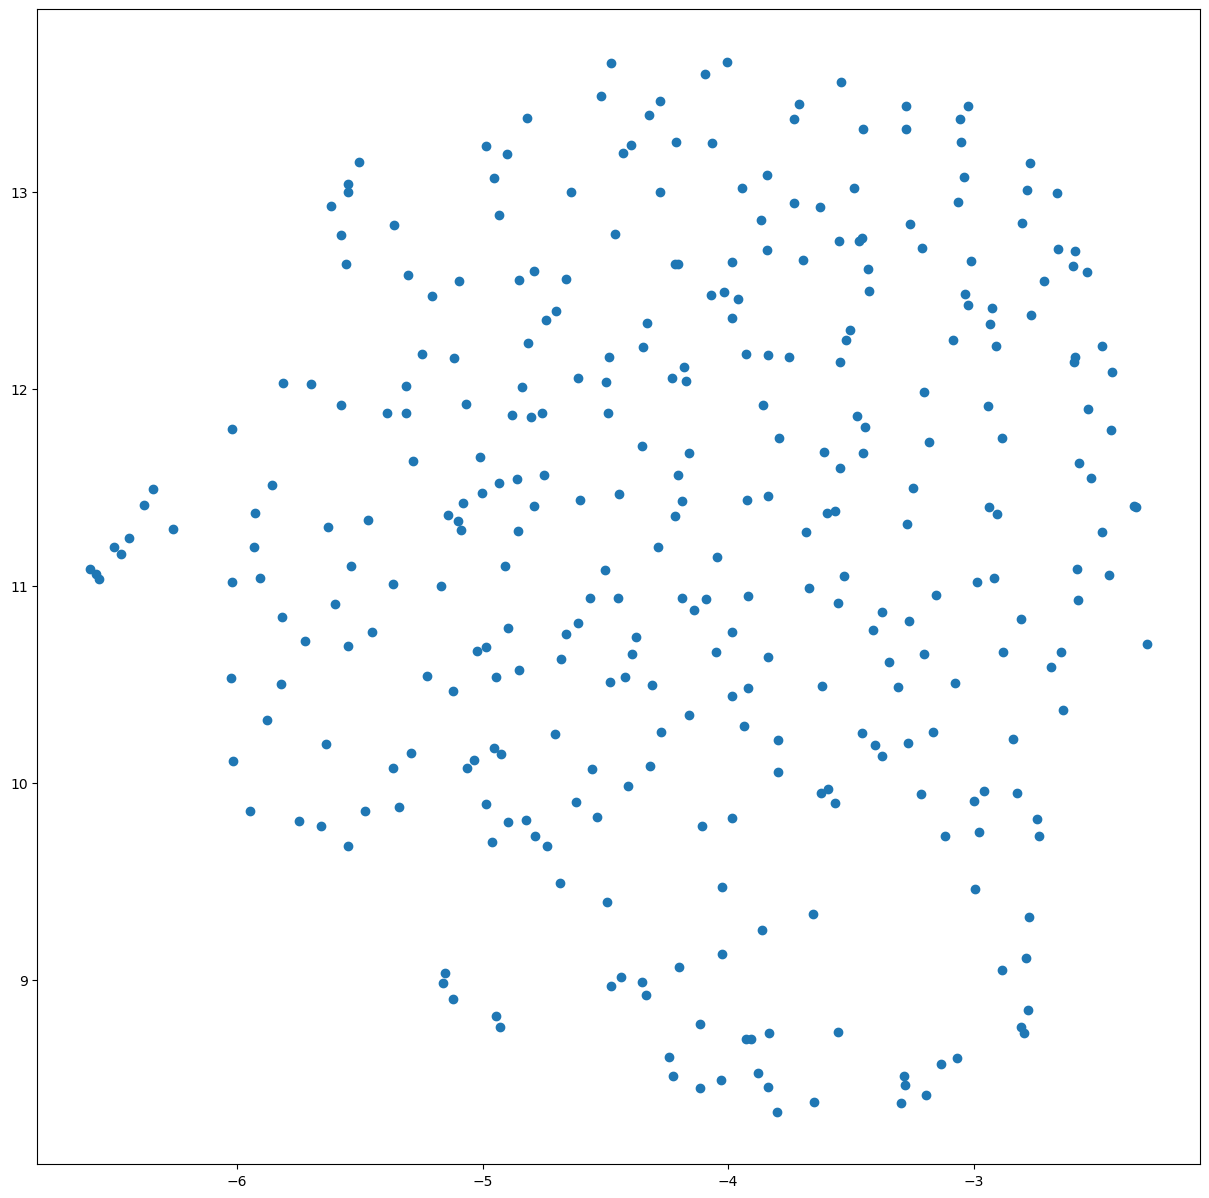

In [176]:
# Gràfic artistes
plt.figure(figsize=(15,15))
plt.scatter(umap_artists_transposed[:, 0], umap_artists_transposed[:, 1])
plt.show()

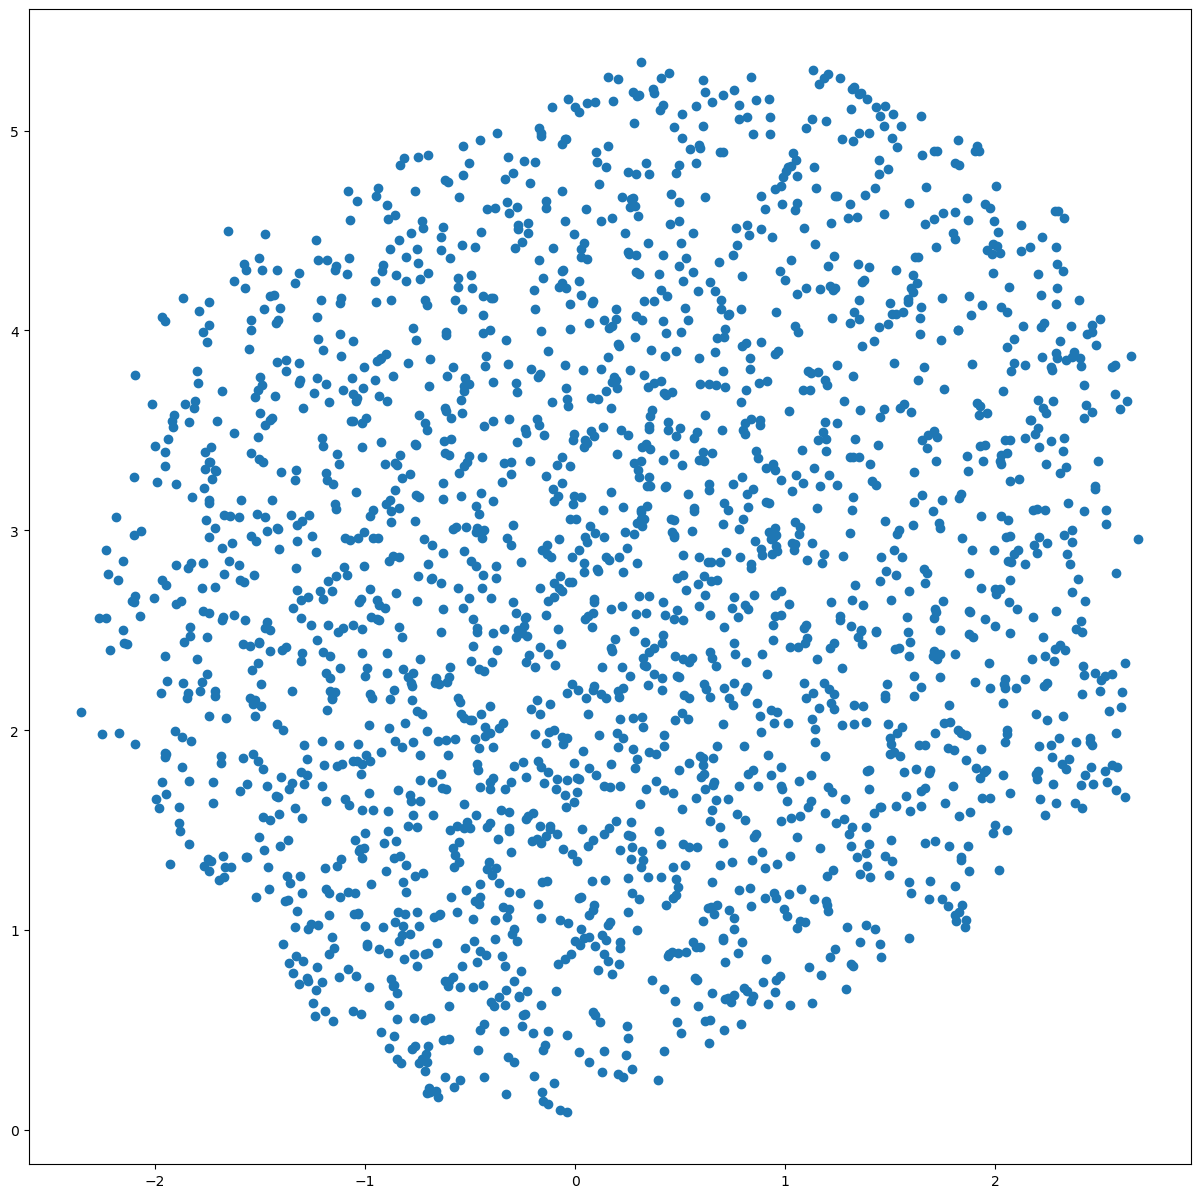

In [177]:
# Gràfic cançons
plt.figure(figsize=(15,15))
plt.scatter(umap_songs_transposed[:, 0], umap_songs_transposed[:, 1])
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Què observes a les noves representacions d'artistes i cançons?
</div>

En la visualització del cas de la transposició de la matriu d'artistes les agrupacions son encara menys evidents, és a dir, costa més "crear" algun _cluster_ atès que els punts estàn més separats que abans.

En el cas de la transposició de la matriu de cançons, s'observa qye els 3 o 4 _clusters_ que es podien identificar, ja no existeixen. De fet, en la visualització de la transposició de la matriu de cançons no es pot observar ningun agrupament obvi ni rellevant.

**Documentació consultada:**

[SciPy.(nd)._scipy.sparse.csr_matrix.transpose_.SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.transpose.html)

## 3. Projecció del gust musical amb LDA (3 punts)

En aquesta secció explorarem una tècnica diferent per reduir la dimensionalitat del gust musical: **LDA (Latent Dirichlet Allocation)**.

A diferència de tècniques com matriu de coocurrència + PCA, t-SNE o UMAP, que busquen per una banda representar l'usuari i reduir aquesta representació a menys dimensions, **LDA té un enfocament més interpretatiu**: tracta de **descobrir temes latents** que expliquen com es combinen els elements observats.

## 3.1 Projecció i clustering amb LDA

**LDA** és un model probabilístic originalment dissenyat per a l'**anàlisi de temes en textos** (topic modeling). Suposa que cada document (en el nostre cas, usuari) està format per una **combinació de temes ocults** (per exemple: 40% Pop, 20% Rock, 5% Rap...). I que cada tema està format per una **combinació de paraules (o artistes, en el nostre cas)**.

Cada **usuari** serà tractat com un "document". Cada **artista** serà com una "paraula". El model intentarà descobrir **temes musicals** (grups d'artistes que solen aparèixer junts en els gustos dels usuaris).

El resultat és una representació de cada usuari com un vector de **probabilitats sobre temes latents**, que podem visualitzar, comparar o usar com a entrada a altres models.

Per entendre LDA amb una explicació visual molt clara, recomanem [aquest vídeo](https://youtu.be/1_jq_gWFUuQ).

Pots utilitzar la implementació de [LDA a scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html). El nombre de temes latents és un paràmetre del model (com la *k* de *k-means*).

Amb LDA pots obtenir tant la projecció d'usuaris a l'espai de temes latents, com els artistes o cançons a l'espai de temes latents. Per assegurar-te de si el resultat es correspon amb els usuaris o els artistes o cançons, pots comprovar la dimensió de la matriu obtinguda.

Per exemple, si el resultat és una matriu `n_topics` X (`n_artists` o `n_songs`) en funció de la matriu emprada. Estàs obtenint la projecció d'artistes o cançons a l'espai de temes latents. Atès que LDA estima probabilísticament cada paraula (artista o cançó) a un tema latent. En aquest cas, els usuaris equivalen als documents que relacionen les paraules entre si.

D'altra banda, també pots obtenir (amb una altra crida) la matriu `n_users` X `n_topics`, que representa la projecció dels usuaris a l'espai de temes latents.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Aplica LDA sobre la matriu `user_artist_matrix` per descobrir temes musicals i mostra, per a cada clúster (o tema) el top 15 d'artistes. Per seleccionar el valor adequat del paràmetre "temes latents", analitza els artistes que apareixen a cada clúster i tracta que tinguin un nexe comú (siguin homogenis).
</div>

## 3.2 Visualització d'usuaris

Ara que has triat un nombre de temes latents tractant que els grups siguin relativament homogenis, visualitza el resultat per comprovar si existeix certa estructura en la projecció.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Visualitza amb matplotlib els usuaris projectats a l'espai de temes latents (si té més de 2 dimensions redueix la dimensionalitat aplicant UMAP) utilitzant com a color de cada usuari el del seu tema latent més rellevant (de valor més alt).
</div>

## 3.3 Visualització d'artistes i cançons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Visualitza amb matplotlib la projecció d'artistes i de cançons a l'espai latent de la dimensió seleccionada anteriorment. Mostra aleatòriament les etiquetes (nom de l'artista o títol de la cançó) de 100 punts juntament amb aquests. No mostris totes les etiquetes perquè taparien el contingut del gràfic.
</div>

## 3.4 Anàlisi de resultats

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Què observes a les noves representacions d'artistes i cançons respecte a les anteriors? A què creus que es deuen aquestes diferències?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Si haguessis de recomanar artistes o cançons noves a un usuari en base al que has après amb LDA, com ho faries?
</div>

## 4. Projectar per recomanar: factorització de matrius (3 punts)

Fins ara hem usat coocurrència i LDA per representar els usuaris i detectar patrons d'escolta. Però... i si existís una projecció pensada específicament per **recomanar**?

Aquí entra en joc una nova família de mètodes: **factorització de matrius**.

Aquests mètodes s'han convertit en una de les eines més utilitzades en sistemes de recomanació (sí, com el de Netflix o Spotify), perquè permeten:

- **Predir quines cançons o artistes agradaran a cada usuari**.
- **Reduir la dimensionalitat** i representar tant usuaris com ítems (artistes o cançons) en un **mateix espai vectorial**.
- **Aprendre afinitats**: si un usuari i un artista tenen vectors similars, és probable que aquest usuari gaudeixi d'aquest artista.

Alguns dels models de recomanació més coneguts:

- **SVD (Singular Value Decomposition)**: descompon la matriu en components ortogonals, útil quan tenim una matriu densa.
- **NNMF (Non-negative Matrix Factorization)**: com SVD, però imposa que els factors siguin positius, la qual cosa facilita la interpretació (no hi ha gustos negatius).
- **ALS (Alternating Least Squares)**: molt usat en sistemes de recomanació, especialment amb matrius disperses. Alterna entre actualitzar usuaris i ítems fins a convergir.
- **BPR (Bayesian Personalized Ranking)**: orientat a recomanacions per rànquing, no per puntuació.
- **LightFM o DeepFM**: integren contingut i interacció en models híbrids (més complexos, no els veurem aquí, però val la pena conèixer-los).

Encara que també estem reduint dimensionalitat, la **finalitat principal no és visualitzar ni interpretar temes**, sinó **reconstruir les preferències faltants a la matriu original**.

Dit d'una altra manera: a LDA, projectàvem usuaris sobre un espai de temes **que explicaven el seu comportament**. A la factorització, projectem usuaris i ítems en un espai on **la seva proximitat indica afinitat**, i podem **predir el que falta**.

![ALS](https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-3-030-03405-4_18/MediaObjects/475251_1_En_18_Fig1_HTML.png)

És una altra manera de "veure les dades", i ens dona noves possibilitats d'anàlisi i recomanació.

## 4.1 Entrenament d'ALS

Atès que les dades del dataset són molt disperses, [ALS](http://yifanhu.net/PUB/cf.pdf) és una bona elecció. Utilitzarem la implementació de la [llibreria implicit](https://github.com/benfred/implicit). Per tenir una intuïció del seu funcionament, recomanem [aquest vídeo](https://youtu.be/DJR_6fkG66s).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena un model ALS amb la matriu de coocurrència precalculada user_artist_matrix i emmagatzema a les variables user_embeddings i artist_embeddings els factors latents apresos pel model. Pots fer servir el mateix nombre de factors latents que has seleccionat a l'exercici anterior per a LDA.
</div>

## 4.2 Visualització d'usuaris

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Si l'embedding d'usuari té més de dues dimensions, redueix la seva dimensionalitat amb UMAP. Visualitza amb matpltolib els usuaris en el nou espai latent reduït.
</div>

## 4.3 Visualització d'artistes

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Si l'embedding d'artistes té més de dues dimensions, redueix la seva dimensionalitat amb UMAP. Visualitza amb matpltolib els usuaris en el nou espai latent reduït. Mostra aleatòriament les etiquetes (nom de l'artista) de 100 punts juntament amb aquests. No mostris totes les etiquetes perquè taparien el contingut del gràfic.
</div>

## 4.4 Recomanació d'artistes

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Ara que tens el model usuari-artistes entrenat, utilitza el mètode recommend per mostrar el top 10 de recomanacions per a un usuari qualsevol. Mostra també els artistes que ha consumit aquest usuari. Tenen relació?
</div>

## 4.5 Entrenament i recomanació de cançons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Calcula l'embedding de les cançons. Si té més de dues dimensions, redueix la seva dimensionalitat amb UMAP. Visualitza amb matpltolib els usuaris en el nou espai latent reduït. Mostra aleatòriament les etiquetes (nom de l'artista) de 100 punts juntament amb aquests. No mostris totes les etiquetes perquè taparien el contingut del gràfic.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quin enfocament de clustering utilitzaries? I quin algoritme en concret? Per què?
</div>


## [OPCIONAL] 5. El context ho és tot: projectant artistes i cançons amb item2vec

Fins ara hem representat els artistes i cançons com a punts en espais temàtics (LDA) o latents (factorització), centrant-nos en com es relacionen amb els usuaris. Però... què passaria si en lloc de mirar **qui els escolta**, observem **com es consumeixen junts a la pràctica**?

Aquí entra en joc una tècnica inspirada en el processament del llenguatge natural: [**item2vec**](https://arxiv.org/pdf/1603.04259).

És una adaptació del famós model [**word2vec**](https://arxiv.org/pdf/1301.3781), però en lloc de predir paraules en frases, **aprèn a representar ítems (en aquest cas, cançons o artistes) a partir del context en què apareixen**. Tot d'una manera no supervisada.

La diferència principal entre word2vec i item2vec rau en què **word2vec assumeix que l'ordre de les paraules importa a la frase, mentre que item2vec no**. Això permet aplicar item2vec a conjunts de dades com carros de la compra on desconeixes l'ordre en què el client va introduir els productes al carro.

La intuïció és simple: si dues cançons solen escoltar-se dins d'una mateixa sessió, probablement comparteixen alguna cosa en comú, **encara que no siguin exactament del mateix gènere**.

Això és molt diferent dels models anteriors:
- **Coocurrència** basat en l'estructura d'escolta.
- **LDA** enfocament probabilístic recolzant-se en temes latents.
- **Factorització** mira preferències individuals.
- **item2vec** **atén al "context d'escolta"**, com si fossin paraules dins de frases.

Un aspecte clau d'item2vec és que dos artistes **no han de necessàriament escoltar-se junts** per acabar projectats *a prop*.
Si **ambdós apareixen en contextos semblants**, es col·loquen a la mateixa zona de l'espai d'embeddings.

Per això, item2vec pot descobrir **afinitats ocultes** entre artistes que mai han coincidit directament, però que comparteixen **un mateix tipus d'oient o ambient d'escolta** (A i B poden no haver coincidit en cap sessió, però A té com a context C, D i E, igual que B).

Un dels aspectes més interessants d'aquest enfocament és la semàntica que és capaç de capturar i forma part dels **fonaments dels LLMs**: la **projecció algebraica permet realitzar operacions al nou espai simplement sumant o restant vectors**, com a la següent imatge.

![Word2Vec](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/06062705/Word-Vectors.png)

Per indagar més en el model word2vec recomanem [aquest article](https://jalammar.github.io/illustrated-word2vec/). També en [aquest vídeo sobre word2vec](https://youtu.be/viZrOnJclY0). I [aquest altre](https://www.youtube.com/watch?v=FJtFZwbvkI4) sobre word embeddings.

## 5.1 Representació matricial artista-artista

La implementació rigorosa ens portaria a un conjunt d'entrenament molt gran (donada la combinatòria) i a implementar tècniques addicionals com negative sampling. Per simplificar-ho, el context d'un artista vindrà donat per la coocurrència amb altres artistes. Per això començarem calculant la matriu `artist_artist_matrix` a partir de la matriu que vam preparar a la primera secció: `user_artist_matrix`. Atès que el context es compararà amb la sortida d'una funció `softmax`, també normalitzarem la matriu per files. D'aquesta manera, les èpoques d'entrenament seran més lleugeres, a la llarga el resultat serà bastant similar, ja que s'acaba aproximant la matriu de coocurrència.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> A partir de la matriu user_artist_matrix, calcula la matriu artist_artist_matrix on cada cel·la indiqui el nombre d'usuaris que han escoltat l'artista de la fila i el de la columna. Normalitza les files de la matriu per entrenar el model.
</div>

Per simplificar la tasca, aquí tens el codi de PyTorch referent al Dataset que carrega la matriu calculada al pas anterior:

## 5.2 Disseny de la xarxa i entrenament

Ara definirem la xarxa neuronal dissenyada perquè, donat un artista, aprengui a predir el seu “context”: els artistes que solen escoltar-se juntament amb ell. Imita el model item2vec amb un enfocament tipus Skip-Gram.

L'implementarem a través de la classe `ArtistModel` que consta dels següents mètodes:

`__init__`

Contindrà una capa d'`Embedding` que projecti a la dimensió que desitgem (en aquest cas 2 per a fins didàctics, ja que aprendrà una representació en baixa dimensionalitat tot en un), que de veritat és el que ens interessa, ja que ens permet associar un índex d'artista a una representació vectorial (embedding). I finalment, una capa `Lineal` que projecti de 2 dimensions al nombre d'artistes (el context).

`forward`

Aquí connectem les capes que hem definit a `__init__` de tal manera que rebem un índex, aquest el passem a la capa d'`Embedding` per recuperar la seva representació vectorial (2d), d'aquí a la capa `Lineal` que projectarà al context (de dimensió nombre d'artistes). Finalment, aplicar i retornar el resultat de la funció `softmax` a la sortida de la capa `Lineal` que al bucle principal (fora del mètode) la compararem amb la fila corresponent de la matriu `artist_artist_matrix`.

El siguiente código se corresponde al bucle de entrenamiento donde relacionamos el dataset que se carga y se conecta con el modelo para alimentarlo.

Destacar:

 - Se ejecutarán 500 epochs, es decir, el modelo verá el dataset completo 500 veces.
 - `for artist_idx, context_dist in artist_dataloader:` aquí se ejecutarán minibatches (el dataset por partes) hasta recorrer el dataset completo (una epoch).
 - `log_probs = model(artist_idx)` se hace una pasada por el modelo entrando un índice y obteniendo su log_probs (la salida).
 - `loss = criterion(log_probs, context_dist)` aquí se comparan las predicciones con el contexto calculado en la matriz `artist_artist_matrix`. Previamente se ha definido `criterion` como `KL divergence` que mide cuanto se alejan las dos distribuciones.
 - `loss.backward()` propaga para atrás las diferencias, haciendo efectivo el entrenamiento de la red.

Durante el proceso de entrenamiento verás como la loss (el error) decrece hasta llegar a estabilizarse.

In [ ]:
model = ArtistModel(n_artists=len(artist_artist_matrix), embedding_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
criterion = nn.KLDivLoss(reduction='batchmean')

n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for artist_idx, context_dist in artist_dataloader:
        log_probs = model(artist_idx)
        loss = criterion(log_probs, context_dist)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(artist_dataloader)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")

## 5.3 Visualització d'artistes

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Recupera els embeddings apresos pel model i visualitza els artistes projectats a l'espai 2d. Mostra aleatòriament les etiquetes (nom de l'artista) de 100 punts juntament amb aquests. No mostris totes les etiquetes perquè taparien el contingut del gràfic.
</div>

La nova representació és una mica diferent de les altres perquè, a diferència de les anteriors, és recomanable utilitzar similitud de cosinus en lloc de la distància euclidiana perquè dos vectors poden apuntar a la mateixa direcció (molt similars), però estar a diferent escala (longitud).

Per exemple: [1, 1] i [100, 100] estan molt lluny euclidianament, però apunten exactament a la mateixa direcció → són el mateix tipus d'artista, només amb més magnitud (més popular, més escoltat...).

L'euclidiana penalitza l'escala, no només la direcció. Però als embeddings, l'important és la direcció del vector, que representa l'estil, el context o la posició semàntica.

Mentre que la similitud de cosinus oscil·la entre -1 (oposats) i 1 (idèntics). Dos vectors amb similitud cosinus propera a 1 estan a la mateixa direcció, per tant, són similars. I dos vectors amb similitud 0 són ortogonals, sense relació. S'ha observat que la similitud de cosinus encaixa millor la representació de la xarxa amb la interpretació dels embeddings.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Com recomanaries artistes a un usuari amb alguna història d'escolta?
</div>